# Zadanie 3 (7 punktów)

Celem ćwiczenia jest imlementacja metody [Minimax z obcinaniem alpha-beta](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) do gry  Czwórki (ang. Connect Four).

W trakcie ćwiczenia można skorzystać z reposytorium z implementacją gry [Connect Four udostępnionym przez Jakuba Łyskawę](https://github.com/lychanl/two-player-games). Ewentualnie, można zaimplementować samemu grę Connect Four.

Należy zaimplementować co najmniej dwie heurystyki do ewaluacji planszy.  

Implementację algorytmu Minimax (klasa `MiniMaxSolver`) należy przetestować używając różną głębokość przeszukiwania symulując grę "komputer vs komputer". W eksperymentach należy również zademonstrować różnice pomiędzy heurystykami.  

W ramach zadania można zaimplementować dowolną liczbę dodatkowych metod w klasie `MiniMaxSolver`.

Punktacja:

- Działająca metoda Minimax oraz heurystyki do ewaluacji planszy. - **2 pkt**
- Działająca metoda Minimax z obcinaniem alpha-beta. - **1.5 pkt**
- Analiza jakości solvera w zależności od głębokości przeszukiwania - wykresy. - **2pkt**
    - należy zaimplementować w tym celu prostą wizualizację rozgrywki dwóch agentów
- Jakość kodu. - **1.5pkt**

Aby importowanie elementów z poniższej komórki działało należy umieścić tego notebooka w tym samym folderze co paczkę `two_player_games`:
```
├── LICENSE
├── README.md
├── minimax.ipynb # <<< HERE
├── test
│   ├── __init__.py
│   ├── test_connect_four.py
│   ├── test_dots_and_boxes.py
│   └── test_pick.py
└── two_player_games
    ├── __init__.py
    ├── games
    │   ├── connect_four.py
    │   └── dots_and_boxes.py
    ├── move.py
    ├── player.py
    └── state.py
```

In [154]:
from typing import Tuple, List
from two_player_games.player import Player
from two_player_games.games.connect_four import ConnectFour, ConnectFourMove, ConnectFourState
import numpy as np
from random import choice
import matplotlib.pyplot as plt
import time

In [155]:
ROW_COUNT = 6
COLUMN_COUNT = 7

In [156]:
class MinMaxSolver:
    def __init__(self, game: ConnectFour, row_count: int, column_count: int, max_player: Player, min_player: Player, heuristic_number=2):
        self._game = game
        self._row_count = row_count
        self._column_count = column_count
        self._max_player = max_player
        self._min_player = min_player
        self._heuristic_number = heuristic_number
        
        # weights for the amount of player tokens in a segment in the future iteration
        self._heuristic2_prizes = {
            "players_one_in_segment": 1,
            "players_two_in_segment": 5,
            "players_three_in_segment": 20,
            "players_four_in_segment": 30,
            "opponent_four_in_segment": 90
        }
        
        self._heuristic2_coefficients = [
            [1,  2,  3,  4,  3,  2,  1],
            [2,  4,  6,  8,  6,  4,  2],
            [3,  6,  9, 12,  9,  6,  3],
            [3,  6,  9, 12,  9,  6,  3],
            [2,  4,  6,  8,  6,  4,  2],
            [1,  2,  3,  4,  3,  2,  1]
        ]
    
    def get_heuristic(self, current_state: ConnectFourState) -> float:
        if self._heuristic_number == 1:
            return self._get_heuristic1(current_state)
        elif self._heuristic_number == 2:
            return self._get_heuristic2(current_state)
        
    def _get_heuristic1(self, current_state: ConnectFourState) -> float:
        player_multipliers = {
            self._max_player: 1,
            self._min_player: -1,
        }
    
        heuristic = 0
        for column in range(self._column_count):
            for row in range(self._row_count):
                field = current_state.fields[column][row]
                if field is not None:
                    coefficient = self._heuristic2_coefficients[row][column]
                    heuristic += coefficient * player_multipliers[field]
    
        return heuristic
    
    def _get_heuristic2(self, current_state: ConnectFourState) -> float:
        heuristics_value = 0
        
        # Horizontal
        for column in range(self._column_count - 3):
            for row in range(self._row_count):
                segment = [current_state.fields[column + i][row] for i in range(4)]
                heuristics_value += self._get_segment_heuristic2(segment)
                
        # Vertical
        for column in range(self._column_count):
            for row in range(self._row_count - 3):
                segment = [current_state.fields[column][row + i] for i in range(4)]
                heuristics_value += self._get_segment_heuristic2(segment)

        # Diagonal
        for column in range(self._column_count - 3):
            for row in range(self._row_count - 3):
                segment = [current_state.fields[column + i][row + i] for i in range(4)]
                heuristics_value += self._get_segment_heuristic2(segment)

        # Antydiagonal
        for column in range(self._column_count - 3):
            for row in range(3, self._row_count):
                segment = [current_state.fields[column + i][row - i] for i in range(4)]
                heuristics_value += self._get_segment_heuristic2(segment)

        return heuristics_value

    def _get_segment_heuristic2(self, segment: List):
        heuristics_value = 0
        
        if segment.count(self._max_player) == 4:
            heuristics_value += self._heuristic2_prizes["players_four_in_segment"]
        elif segment.count(self._max_player) == 3 and segment.count(None) == 1:
            heuristics_value += self._heuristic2_prizes["players_three_in_segment"]
        elif segment.count(self._max_player) == 2 and segment.count(None) == 2:
            heuristics_value += self._heuristic2_prizes["players_two_in_segment"]
        elif segment.count(self._max_player) == 1 and segment.count(None) == 3:
            heuristics_value += self._heuristic2_prizes["players_one_in_segment"]
        elif segment.count(self._min_player) == 3 and segment.count(None) == 1:
            heuristics_value -= self._heuristic2_prizes["opponent_four_in_segment"]
        elif segment.count(self._min_player) == 1 and segment.count(None) == 3:
            heuristics_value -= self._heuristic2_prizes["players_one_in_segment"]

        return heuristics_value

    def is_valid_move(self, current_state, col_index:int) -> bool:
        if current_state.fields[col_index][-1] is None:
            return True
        else:
            return False
    
    def get_best_move(self, depth: int, solver=1) -> int|None:
        move = None
        if solver == 1:
            move, value = self.minimax_alpha_beta(self._game.state, depth)
        elif solver == 2:
            move, value = self.minimax(self._game.state, depth)
        return move
        
    def minimax_alpha_beta(self, current_state: ConnectFourState, depth: int, alpha=-np.inf, beta=np.inf, 
                           is_maximizing_player=True) -> Tuple[int|None, float]:
        if current_state.is_finished():
            if current_state.get_winner() == self._max_player:
                return None, 1e6
            elif current_state.get_winner() == self._min_player:
                return None, -1e6
            else:
                return None, 0
        if depth == 0:
            return None, self.get_heuristic(current_state)

        valid_moves = self._game.get_moves()
        chosen_move = choice(valid_moves)
        
        if is_maximizing_player:
            value = -np.inf
            for valid_move in valid_moves:
                _, heuristic = self.minimax_alpha_beta(current_state.make_move(valid_move), depth - 1, alpha, beta, False)

                if heuristic > value:
                    value = heuristic
                    chosen_move = valid_move

                alpha = max(alpha, value)

                if alpha >= beta:
                    break
                    
        else:
            value = np.inf
            for valid_move in valid_moves:
                _, heuristic = self.minimax_alpha_beta(current_state.make_move(valid_move), depth - 1, alpha, beta, True)

                if heuristic < value:
                    value = heuristic
                    chosen_move = valid_move

                beta = min(beta, value)

                if alpha >= beta:
                    break

        return chosen_move, value
    
    def minimax(self, current_state: ConnectFourState, depth: int, is_maximizing_player=True) -> Tuple[int|None, float]:
        if current_state.is_finished():
            if current_state.get_winner() == self._max_player:
                return None, 1e6
            elif current_state.get_winner() == self._min_player:
                return None, -1e6
            else:
                return None, 0
        if depth == 0:
            return None, self.get_heuristic(current_state)
        
        valid_moves = self._game.get_moves()
        chosen_moves = []
        if is_maximizing_player:
            value = -np.inf
            for valid_move in valid_moves:
                _, heuristic = self.minimax(current_state.make_move(valid_move), depth - 1, False)
                
                if heuristic >= value:
                    value = heuristic
                    chosen_moves.append((valid_move, heuristic))
            
            best_moves = [move for move, heuristic in chosen_moves if heuristic == value]
            return choice(best_moves), value
        
        else:
            value = np.inf
            for valid_move in valid_moves:
                # print(f"valid_move: {valid_move}")
                _, heuristic = self.minimax(current_state.make_move(valid_move), depth - 1, True)
                
                if heuristic <= value:
                    value = heuristic
                    chosen_moves.append((valid_move, heuristic))
            
            best_moves = [move for move, heuristic in chosen_moves if heuristic == value]
            return choice(best_moves), value

## Funkcja do symulacji rozgrywki

In [168]:
def simulate(row_count: int, column_count: int, max_player_type: str, min_player_type: str,
             max_player_depth: int, min_player_depth: int, max_player_heuristic_type: int, min_player_heuristic_type: int,
             games_number: int, verbose=0):
    max_player_win_number = 0
    min_player_win_number = 0
    max_player = Player("O")
    min_player = Player("X")
    
    game = ConnectFour(size=(column_count, row_count), first_player=max_player, second_player=min_player)
    solver1 = MinMaxSolver(game, row_count, column_count, max_player, min_player, max_player_heuristic_type)
    solver2 = MinMaxSolver(game, row_count, column_count, min_player, max_player, min_player_heuristic_type)
    
    moves_sum = 0
    
    for game_index in range(games_number):
        game = ConnectFour(size=(column_count, row_count), first_player=max_player, second_player=min_player)
        solver1._game = game
        solver2._game = game
        
        if verbose != 0:
            print(20*"----")
            print("początek gry")
        
        i = 0
        while not game.is_finished():
            if max_player_type == "alpha-beta":
                game.make_move(solver1.get_best_move(max_player_depth, 1))
            elif max_player_type == "min-max":
                game.make_move(solver1.get_best_move(max_player_depth, 2))
            
            if verbose == 3:
                print(10*"----")
                print(f"Move number: {i} by max player done")
                print(game)
            
            i += 1
            if game.state.is_finished():
                break
            
            if min_player_type == "alpha-beta":
                game.make_move(solver2.get_best_move(min_player_depth, 1))
            elif min_player_type == "min-max":
                game.make_move(solver2.get_best_move(min_player_depth, 2))
            
            if verbose == 3:
                print(10*"----")
                print(f"Move number: {i} by min player done")
                print(game)
            
            i += 1
        
        moves_sum += i
        
        if verbose != 0:
            print(20*"----")
            print(f"Game number: {game_index}/{games_number}")
            print(f"Moves: {i}")
            if verbose >= 2:
                print(game)
            if game.get_winner() is not None:
                if game.get_winner().char == max_player.char:
                    print(f"Won: {game.get_winner().char}")
                    max_player_win_number += 1
                elif game.get_winner().char == min_player.char:
                    print(f"Won: {game.get_winner().char}")
                    min_player_win_number += 1
            else:
                print("Draw 1:1")
        
    
    draws_number = games_number - max_player_win_number - min_player_win_number
    average_moves_number = moves_sum/games_number
    
    print(30*"----")
    print(f"Games number: {games_number}")
    print(f"Average moves number: {average_moves_number}")
    print(f"Draws: {draws_number} ({(draws_number/games_number)*100}%)")
    print(f"Max player won: {max_player_win_number} ({(max_player_win_number/games_number)*100}%)")
    print(f"Min player won: {min_player_win_number} ({(min_player_win_number/games_number)*100}%)")
    print(30*"----")

## Symulacja rozgrywki i pierwsze testy

In [158]:
simulate(ROW_COUNT, COLUMN_COUNT, max_player_type="alpha-beta", min_player_type="alpha-beta",
         max_player_depth=2, min_player_depth=2, max_player_heuristic_type=2, min_player_heuristic_type=2,
         games_number=10, verbose=2)

--------------------------------------------------------------------------------
początek gry
--------------------------------------------------------------------------------
Game number: 0/10
Moves: 35
Current player: X
[X][X][ ][O][O][ ][X]
[X][O][ ][X][O][ ][O]
[O][O][O][O][X][ ][X]
[X][X][X][O][O][ ][O]
[X][O][O][X][O][ ][O]
[X][O][X][O][X][X][X]
Won: O
--------------------------------------------------------------------------------
początek gry
--------------------------------------------------------------------------------
Game number: 1/10
Moves: 35
Current player: X
[X][X][ ][O][O][ ][X]
[X][O][ ][X][O][ ][O]
[O][O][O][O][X][ ][X]
[X][X][X][O][O][ ][O]
[X][O][O][X][O][ ][O]
[X][O][X][O][X][X][X]
Won: O
--------------------------------------------------------------------------------
początek gry
--------------------------------------------------------------------------------
Game number: 2/10
Moves: 35
Current player: X
[X][X][ ][O][O][ ][X]
[X][O][ ][X][O][ ][O]
[O][O][O][O][X]

## Funkcja do symulacji i zbierania statystyk gry

In [159]:
def simulation_and_statistics(row_count: int, column_count: int, 
                              max_player_type: str, min_player_type: str,
                              max_player_heuristic_type: int, min_player_heuristic_type: int,
                              max_player_min_depth: int, max_player_max_depth: int, min_player_depth: int,
                              games_per_depth: int):
    
    depths = list(range(max_player_min_depth, max_player_max_depth + 1))
    avg_times_per_move = [] 
    win_percentages = [] 
    
    max_player = Player("O")
    min_player = Player("X")

    for depth in depths:
        print(f"Simulating for depth: {depth}")
        total_max_player_time = 0
        max_player_wins_number = 0
        max_player_loses_number = 0
        draws_number = 0

        for _ in range(games_per_depth):
            game = ConnectFour(size=(column_count, row_count), first_player=max_player, second_player=min_player)

            solver1 = MinMaxSolver(game, row_count, column_count, max_player, min_player, max_player_heuristic_type)
            solver2 = MinMaxSolver(game, row_count, column_count, min_player, max_player, min_player_heuristic_type)

            moves_sum = 0
            while not game.is_finished():
                start_time = time.time()
                
                if max_player_type == "alpha-beta":
                    game.make_move(solver1.get_best_move(depth, 1))
                elif max_player_type == "min-max":
                    game.make_move(solver1.get_best_move(depth, 2))
                    
                elapsed_time = time.time() - start_time
                total_max_player_time += elapsed_time

                moves_sum += 1
                if game.state.is_finished():
                    break

                if min_player_type == "alpha-beta":
                    game.make_move(solver2.get_best_move(min_player_depth, 1))
                elif min_player_type == "min-max":
                    game.make_move(solver2.get_best_move(min_player_depth, 2))

                moves_sum += 1
            
            if game.get_winner() is not None:
                if game.get_winner().char == max_player.char:
                    max_player_wins_number += 1
                elif game.get_winner().char == min_player.char:
                    max_player_loses_number += 1
            else:
                draws_number += 1

        avg_time_per_game = total_max_player_time / games_per_depth
        avg_times_per_move.append(avg_time_per_game / moves_sum) 
        win_percentage = (max_player_wins_number / games_per_depth) * 100
        win_percentages.append(win_percentage)

        print(f"Depth: {depth}; \tAverage max_player time per move: {avg_times_per_move[-1]:.4f}s")
        print(f"\t\t\tDraws: {draws_number} ({(draws_number/games_per_depth)*100}%)")
        print(f"\t\t\tMax player won: {max_player_wins_number} ({(max_player_wins_number/games_per_depth)*100}%)")
        print(f"\t\t\tMax player lost: {max_player_loses_number} ({(max_player_loses_number/games_per_depth)*100}%)")

    plt.plot(depths, avg_times_per_move, marker='o')
    plt.grid()
    plt.ylabel("Głębokość przeszukiwania")
    plt.xlabel("Średni czas wykonywania ruchu")
    plt.title("Szybkość działania solvera w funkcji głębokości przeszukiwania")
    plt.show()
    
    plt.plot(depths, win_percentages, marker='o')
    plt.grid()
    plt.ylabel("Głębokość przeszukiwania")
    plt.xlabel("Współczynnik zwycięstw")
    plt.title("Współczynnik zwycięstw solvera w funkcji głębokości przeszukiwania")
    plt.show()

## Eksperyment 1
Wykonano po 20 partii dwóch graczów używających algorytmu mini-max z tą samą heurystyką. Głębokość przeszukiwania pierwszego zmieniała się od 2 do 6, natomiast gracz drugi miał stałą głębokość przeszukiwania równą 3.

Simulating for depth: 2
Depth: 2; 	Average max_player time per move: 0.0065s
			Draws: 2 (10.0%)
			Max player won: 9 (45.0%)
			Max player lost: 9 (45.0%)
Simulating for depth: 3
Depth: 3; 	Average max_player time per move: 0.0255s
			Draws: 1 (5.0%)
			Max player won: 4 (20.0%)
			Max player lost: 15 (75.0%)
Simulating for depth: 4
Depth: 4; 	Average max_player time per move: 0.1669s
			Draws: 6 (30.0%)
			Max player won: 6 (30.0%)
			Max player lost: 8 (40.0%)
Simulating for depth: 5
Depth: 5; 	Average max_player time per move: 0.9458s
			Draws: 7 (35.0%)
			Max player won: 4 (20.0%)
			Max player lost: 9 (45.0%)
Simulating for depth: 6
Depth: 6; 	Average max_player time per move: 6.0878s
			Draws: 7 (35.0%)
			Max player won: 13 (65.0%)
			Max player lost: 0 (0.0%)


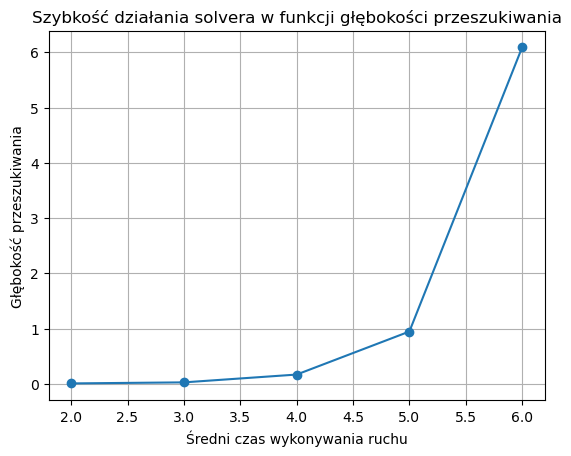

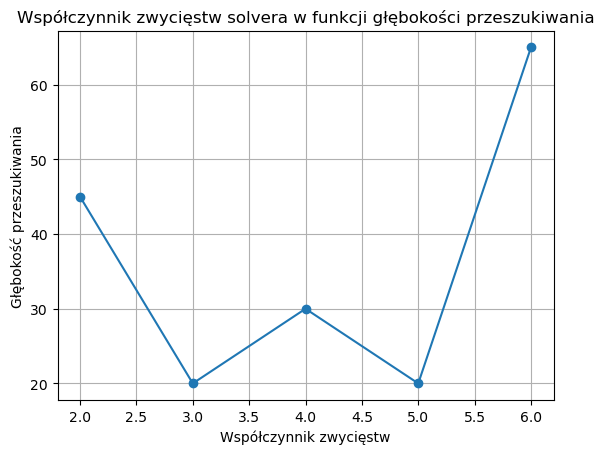

In [160]:
simulation_and_statistics(ROW_COUNT, COLUMN_COUNT, max_player_type="min-max", min_player_type="min-max", max_player_heuristic_type=2, min_player_heuristic_type=2, max_player_min_depth=2, max_player_max_depth=6, min_player_depth=3, games_per_depth=20)

Pierwszy wykres pokazuje istotną wadę algorytmu min-max, czyli złożoność obliczeniową, która rośnie wykładniczo wraz z głębokością przeszukiwania. Występuje tzw. eksplozja kombinatoryczna polegająca na tym, że ilość wszystkich kombinacji wszystkich gałęzi drzewa, które należy przeszukać, rośnie bardzo szybko. W przypadku największej głębokości przeszukiwania czas wykonania ruchu wyniósł ponad 6 sekund, co sprawiło, że eksperyment wykonywał się niecałe 2h.
Natomiast sytuacja na wykresie drugim jest nieoczywista, teoretycznie współczynnik zwycięstw powinien rosnąć wraz ze wzrostem głębokości przeszukiwania, jednak w tym przypadku otrzymana zależność nie jest monotoniczna. Może to wynikać z nie najlepszych współczynników heurystyki 2. W algorytmie min-max aktualny ruch jest wybierany losowo z możliwych ruchów o tej samej najlepszej heurystyce. Być może wprowadzenie tej losowości powoduje uzyskiwanie takich nieoczywistych wyników.

## Ekspetyment 2
Tym razem obaj gracze o takich samych parametrach jak poprzednio korzystali z algorytmu alpha-beta. Jako że jest to algorytm deterministyczny, w celu skórcenia czasu symulacji, ograniczono się do ograniczenia rozgrywanych partii do 1.

Simulating for depth: 2
Depth: 2; 	Average max_player time per move: 0.0033s
			Draws: 0 (0.0%)
			Max player won: 1 (100.0%)
			Max player lost: 0 (0.0%)
Simulating for depth: 3
Depth: 3; 	Average max_player time per move: 0.0103s
			Draws: 0 (0.0%)
			Max player won: 0 (0.0%)
			Max player lost: 1 (100.0%)
Simulating for depth: 4
Depth: 4; 	Average max_player time per move: 0.0392s
			Draws: 1 (100.0%)
			Max player won: 0 (0.0%)
			Max player lost: 0 (0.0%)
Simulating for depth: 5
Depth: 5; 	Average max_player time per move: 0.1212s
			Draws: 1 (100.0%)
			Max player won: 0 (0.0%)
			Max player lost: 0 (0.0%)
Simulating for depth: 6
Depth: 6; 	Average max_player time per move: 0.6454s
			Draws: 1 (100.0%)
			Max player won: 0 (0.0%)
			Max player lost: 0 (0.0%)


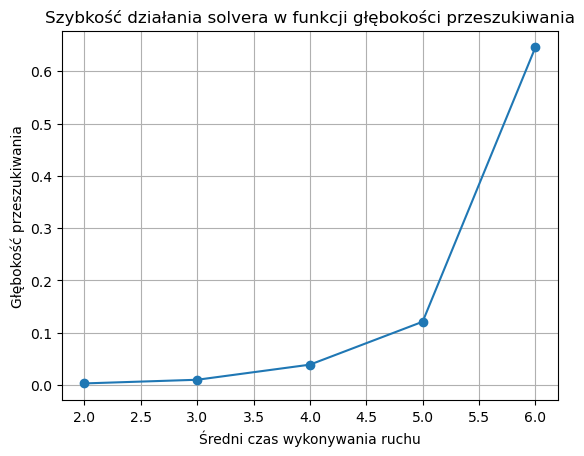

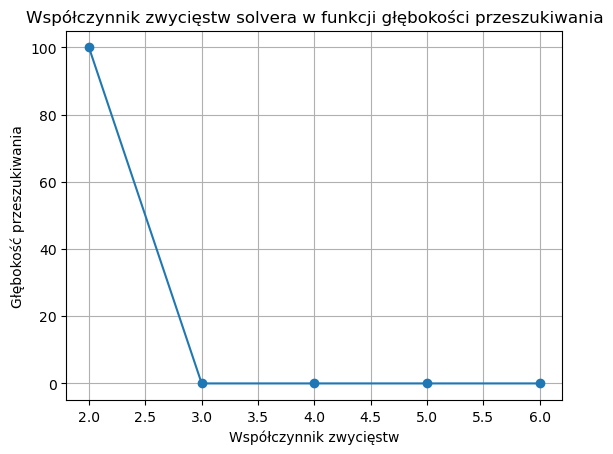

In [161]:
simulation_and_statistics(ROW_COUNT, COLUMN_COUNT, max_player_type="alpha-beta", min_player_type="alpha-beta", max_player_heuristic_type=2, min_player_heuristic_type=2, max_player_min_depth=2, max_player_max_depth=6, min_player_depth=3, games_per_depth=1)

W tym przypadku działanie algorytmu jest jeszcze dziwniejsze i gorsze. Tym razem gracz o większej głębokości przeszukiwania przegrywał. Jednak wynik tego algorytmu nie jest sprzeczny z wynikiem poprzedniego eksperymentu. Wynika z tego, że zastosowana heurystyka nie zawsze daje najlepszy wynik. W algorytmie min-max ruch wybierany był losowo spośród kilku najlepszych, a w tym przypadku za każdym uruchomieniem algorytmu z tymi samymi parametrami, wybierane jest to samo rozwiązanie. Jak widać, w tych przypadkach jest to rozwiązanie, które nie doprowadza do wygranej. Jednak na wykresie widać też zaletę algorytmu alpha-beta, czyli mniejszą złożoność obliczeniową - dla maksymalnej długości przeszukiwania czas wykonywania ruchu był prawie 10 razy krótszy.

## Eksperyment 3
Tym razem, tak jak w pierwszym eksperymencie, obaj gracze używali algorytmu min-max, tym razem jednak używając innej heurystyki. 

Simulating for depth: 2
Depth: 2; 	Average max_player time per move: 0.0016s
			Draws: 1 (20.0%)
			Max player won: 2 (40.0%)
			Max player lost: 2 (40.0%)
Simulating for depth: 3
Depth: 3; 	Average max_player time per move: 0.0063s
			Draws: 0 (0.0%)
			Max player won: 3 (60.0%)
			Max player lost: 2 (40.0%)
Simulating for depth: 4
Depth: 4; 	Average max_player time per move: 0.0611s
			Draws: 4 (80.0%)
			Max player won: 1 (20.0%)
			Max player lost: 0 (0.0%)
Simulating for depth: 5
Depth: 5; 	Average max_player time per move: 0.4221s
			Draws: 0 (0.0%)
			Max player won: 5 (100.0%)
			Max player lost: 0 (0.0%)
Simulating for depth: 6
Depth: 6; 	Average max_player time per move: 6.5490s
			Draws: 0 (0.0%)
			Max player won: 5 (100.0%)
			Max player lost: 0 (0.0%)


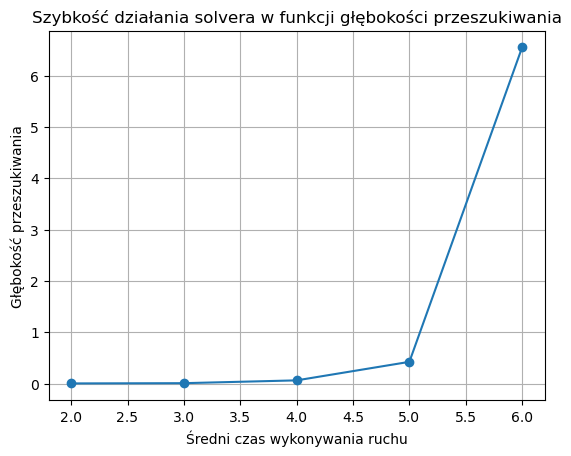

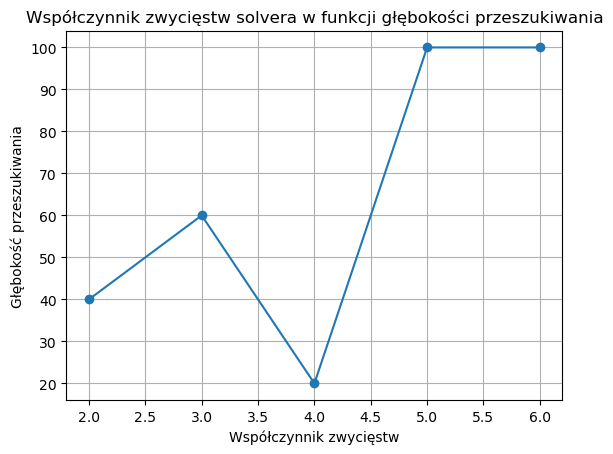

In [163]:
simulation_and_statistics(ROW_COUNT, COLUMN_COUNT, max_player_type="min-max", min_player_type="min-max", max_player_heuristic_type=1, min_player_heuristic_type=1, max_player_min_depth=2, max_player_max_depth=6, min_player_depth=3, games_per_depth=5)

Jak się okazuje, heurystyka ta, mimo że wydaje się być prostsza, działa trochę wolniej niż heurystyka 2 z eksperymentu 1, jednak przynosi lepsze rezultaty, zwłaszcza dla większych głębokości przeszukiwań. Heurystyka 1 bazuje na prawdopodobieństwie uzyskiwania dobrych wyników przy obsadzaniu danych pól na planszy. Widać tutaj tego rezultat - działa ona najlepiej przy dużej ilości prób, czyli przy dużej głębokości przeszukiwania.

## Eksperyment 4
W eksperymencie tym wykonano symulacje graczy o tych samych parametrach co poprzednio, ale tym razem korzystających z algorymtu alpha-beta.

Simulating for depth: 2
Depth: 2; 	Average max_player time per move: 0.0025s
			Draws: 0 (0.0%)
			Max player won: 5 (100.0%)
			Max player lost: 0 (0.0%)
Simulating for depth: 3
Depth: 3; 	Average max_player time per move: 0.0094s
			Draws: 0 (0.0%)
			Max player won: 5 (100.0%)
			Max player lost: 0 (0.0%)
Simulating for depth: 4
Depth: 4; 	Average max_player time per move: 0.0202s
			Draws: 5 (100.0%)
			Max player won: 0 (0.0%)
			Max player lost: 0 (0.0%)
Simulating for depth: 5
Depth: 5; 	Average max_player time per move: 0.1004s
			Draws: 0 (0.0%)
			Max player won: 5 (100.0%)
			Max player lost: 0 (0.0%)
Simulating for depth: 6
Depth: 6; 	Average max_player time per move: 0.5713s
			Draws: 0 (0.0%)
			Max player won: 5 (100.0%)
			Max player lost: 0 (0.0%)


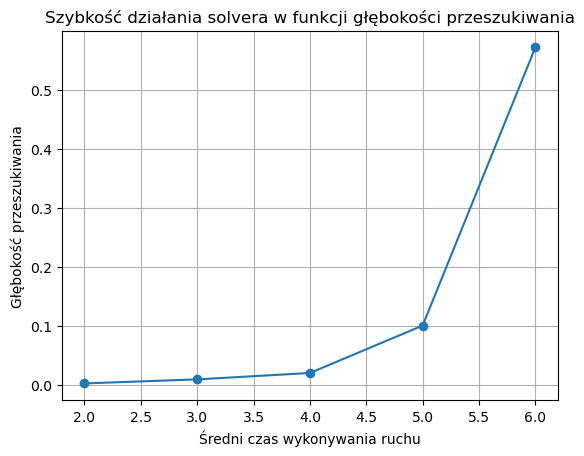

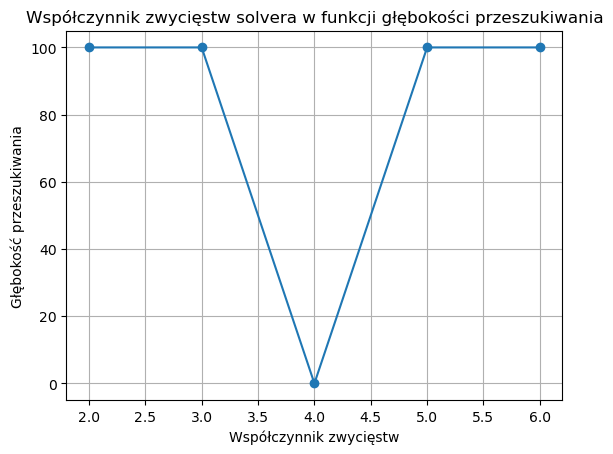

In [165]:
simulation_and_statistics(ROW_COUNT, COLUMN_COUNT, max_player_type="alpha-beta", min_player_type="alpha-beta", max_player_heuristic_type=1, min_player_heuristic_type=1, max_player_min_depth=2, max_player_max_depth=6, min_player_depth=3, games_per_depth=5)

W tej wersji algorytm okazał się być najszybszy wśród wszystkich użytych jego konfiguracji użytych wcześniej. Przyniósł też bardzo dobre rezultaty, jedynie dla głębokości równej 4 wystąpiła anomalia taka, że algorytm przegrał. Przyczyny tego zjawiska zostały opisane wcześniej, wynika to z faktu, że algorytm alpha-beta wybiera zawsze pierwsze dobre rozwiązanie, które przy nieidealnej heurystyce nie zawsze prowadzi do wygranej. Wszystko więc zależy od danego przypadku, jakie rozwiązanie będzie pierwsze znalezione.

## Eksperyment 5
Tym razem uruchomiono prostszą wersję symulacji, mającą sprawdzić działanie algorytmu w przypadku, gdy obaj gracze korzystają z tych samych algorytmów o tych samych parametrach.

In [169]:
simulate(ROW_COUNT, COLUMN_COUNT, max_player_type="min-max", min_player_type="min-max",
         max_player_depth=3, min_player_depth=3, max_player_heuristic_type=2, min_player_heuristic_type=2,
         games_number=10, verbose=0)

------------------------------------------------------------------------------------------------------------------------
Games number: 10
Average moves number: 37.3
Draws: 10 (100.0%)
Max player won: 0 (0.0%)
Min player won: 0 (0.0%)
------------------------------------------------------------------------------------------------------------------------


Wynik algorytmu wyszedł taki, jakiego można było się spodziewać, czyli remis obydwu algorytmów.

## Eksperyment 6
Tym razem obaj gracze mają takie same parametry, tyle że jeden używa algorytmu min-max, a drugi alpha-beta.

In [170]:
simulate(ROW_COUNT, COLUMN_COUNT, max_player_type="min-max", min_player_type="alpha-beta",
         max_player_depth=3, min_player_depth=3, max_player_heuristic_type=2, min_player_heuristic_type=2,
         games_number=10, verbose=0)

------------------------------------------------------------------------------------------------------------------------
Games number: 10
Average moves number: 40.9
Draws: 10 (100.0%)
Max player won: 0 (0.0%)
Min player won: 0 (0.0%)
------------------------------------------------------------------------------------------------------------------------


Tym razem rozgrywka za każdym razem kończyła się remisem.

## Eksperyment 7
Eksperyment ten wykonano, aby porównać obie wersje heurystyki, symulując rozgrywki dwóch graczy o takich samych parametrach, ale korzystających z różnych heurystyk.

In [171]:
simulate(ROW_COUNT, COLUMN_COUNT, max_player_type="alpha-beta", min_player_type="alpha-beta",
         max_player_depth=3, min_player_depth=3, max_player_heuristic_type=1, min_player_heuristic_type=2,
         games_number=10, verbose=0)

------------------------------------------------------------------------------------------------------------------------
Games number: 10
Average moves number: 42.0
Draws: 10 (100.0%)
Max player won: 0 (0.0%)
Min player won: 0 (0.0%)
------------------------------------------------------------------------------------------------------------------------


Tym razem także rozgrywki kończyły się za każdym razem remisem, co może sugerować, że skuteczność heurystyk jest podobna. Większe różnice w nich było widać w pierwszych eksperymentach, gdzie głębokość przeszukiwania przyjmowała większe wartości aż do 6.

## Wnioski
Pierwsze, co wynika z przeprowadzonych eksperymentów, to to, że działanie algorytmu zależy bardzo od użytej heurystyki. Jedne z nich mogą działać lepiej dla małych, jedne dla większych głębokości przeszukiwania. Skuteczność samych heurystyk w dużej mierze zależy od użytych w niej parametrów, które w tym przypadku nie byłby najlepsze, co widać było w przypadku heurystyki 2, która jest bardziej skomplikowana, a więc powinna przynosić lepsze rezultaty. 
Algorytm alpha-beta jest deterministyczny, co oznacza, że za każdym jego odpaleniem z tymi samymi parametrami zwraca te same wyniki, co jest niestety sporą wadą w przypadku gdy heurystyka nie jest najlepsza. Wtedy algorytm może zawsze wybierać ruch, który tak naprawdę nie jest optymalny. Algorytm min-max wybiera ruch spośród kilku najlepszych, a więc pozwala to w sposób losowy uniknąć wybrania jednak nie najkorzystniejszego rozwiązania.